# Naive NN 

We will implement a Feed Forward NN that uses the peptide low-dim vector with the HLA flatten representation for peptide binding classification.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os


In [2]:
# PATH
DATA_FOLDER = os.path.join('..', 'data')
PROCESS_DATA_FOLDER = os.path.join(DATA_FOLDER, 'processed')
PROCESS_pHLA_BINDING_FOLDER = os.path.join(PROCESS_DATA_FOLDER, 'pHLA_binding')

PROCESS_NETMHCPAN_pHLA_FOLDER = os.path.join(PROCESS_pHLA_BINDING_FOLDER, 'NetMHCpan_dataset')

# CONSTANTS
N_WORKERS = 4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_LABELS = 2
N_EPOCHS = 2
EXP_NAME = 'naive_nn'
CHEKPOINT_FOLDER = os.path.join('.', 'checkpoints', EXP_NAME)
os.makedirs(CHEKPOINT_FOLDER, exist_ok=True)

In [3]:
# File paths

# Only using binding affinity data for training
train_data = os.path.join(PROCESS_NETMHCPAN_pHLA_FOLDER, 'train_ba_merged_enc.npy')
train_labels = os.path.join(PROCESS_NETMHCPAN_pHLA_FOLDER, 'train_ba_labels.npy')
test_data = os.path.join(PROCESS_NETMHCPAN_pHLA_FOLDER, 'test_merged_enc.npy')
test_labels = os.path.join(PROCESS_NETMHCPAN_pHLA_FOLDER, 'test_labels.npy')



In [4]:
class Data(Dataset):
    def __init__(self, X_train: np.array, y_train: np.array):
        self.X = torch.from_numpy(X_train.astype(np.float32))
        self.y = torch.from_numpy(y_train).type(torch.float32)
        self.len = self.X.shape[0]
  
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.len

In [9]:

class CNN1d(nn.Module):
    def __init__(self, input_dim: int,
                       n_classes: int, 
                       in_channels: int = 1,
                       hidden_dim: int = 64):
        """
        1D Convolutional Neural Network
        :param input_dim: int, Size of the 1d array
        :param n_classes: int, number of classes to predict
        :param in_channels: int, number of input channels
        :param hidden_dim: int, number of hidden units in the fully connected layer classifier
        """
        super(CNN1d, self).__init__()
        n_ch_cnv1 = 256
        n_ch_cnv2 = 128
        n_ch_cnv3 = 64
        n_ch_cnv4 = 32
        ks_cnv = 11         # kernel size convolutions 
        ks_pool = 2         # kernel size MaxPooling
        s_cnv = 1           # stride convolutions       
        s_pool = 2          # stride MaxPooling       
        #pad = 1            # padding  
        
        
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=n_ch_cnv1,
                      kernel_size=ks_cnv, stride=s_cnv, padding=ks_cnv),
            nn.ELU(),
            nn.MaxPool1d(kernel_size=ks_pool, stride=s_pool),
            nn.Conv1d(in_channels=n_ch_cnv1, out_channels=n_ch_cnv2,
                      kernel_size=ks_cnv-2, stride=s_cnv, padding=ks_cnv-2),
            nn.ELU(),
            nn.MaxPool1d(kernel_size=ks_pool, stride=s_pool),
            nn.Conv1d(in_channels=n_ch_cnv2, out_channels=n_ch_cnv3, 
                      kernel_size=ks_cnv-4, stride=s_cnv, padding=ks_cnv-4),
            nn.ELU(),
            nn.MaxPool1d(kernel_size=ks_pool, stride=s_pool),
            nn.Conv1d(in_channels=n_ch_cnv3, out_channels=n_ch_cnv4,
                      kernel_size=ks_cnv-6, stride=s_cnv, padding=ks_cnv-6),
            nn.ELU(),
            nn.MaxPool1d(kernel_size=ks_pool, stride=s_pool),
            nn.Flatten()
        )
        
        num_conv_pool_pairs = 4
        flatten_vec_size = self.compute_output_size_conv1d(input_size=input_dim, 
                                                           ks_conv=[i for i in range(ks_cnv, 0, -2)][:num_conv_pool_pairs], 
                                                           ks_pool=[ks_pool]*num_conv_pool_pairs, 
                                                           s_conv=s_cnv,
                                                           s_pool=s_pool,
                                                           pad_conv=[i for i in range(ks_cnv, 0, -2)][:num_conv_pool_pairs],
                                                           n_ch_last_layer=n_ch_cnv4,
                                                           num_conv_pool_pairs=num_conv_pool_pairs)
        self.classifier = nn.Sequential(
            nn.Linear(flatten_vec_size, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, n_classes)
        )
        
    def forward(self, x):
        # x: (batch_size, in_channels, input_dim)
        x = self.feature_extractor(x)
        x = self.classifier(x)
        x = F.softmax(x, dim=-1)
        return x
        
    @staticmethod
    def compute_output_size_conv1d(input_size: int, 
                                   ks_conv: list,
                                   ks_pool: list, 
                                   s_conv: int, 
                                   s_pool: int, 
                                   pad_conv: list,
                                   n_ch_last_layer: int, 
                                   num_conv_pool_pairs: int) -> int:
        """
        Compute the output size of a 1d-CNN  
        
        :param input_size: int, input size
        :param ks_conv: list, kernel sizes of the convolution
        :param ks_pool: list, kernel sizes of the MaxPooling
        :param s_conv: int, stride of the convolution
        :param s_pool: int, stride of the MaxPooling
        :param pad_conv: int, padding of the convolution
        :param n_ch_last_layer: int, number of channels of the last convolutional layer
        :param num_conv_pool_pairs: int, number of convolutional and MaxPooling pairs
        :return: int, output size
        """
        output_size = input_size
        for i in range(num_conv_pool_pairs):
            # Convolution
            output_size = (output_size - ks_conv[i] + 2 * pad_conv[i]) // s_conv + 1
            # MaxPooling
            output_size = (output_size - ks_pool[i]) // s_pool + 1
            # Convolution
            #output_size = (output_size - ks_conv + 2 * pad_conv) // s_conv + 1
            # MaxPooling
            #output_size = (output_size - ks_pool) // s_pool + 1
        return output_size * n_ch_last_layer
        
    

In [6]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)    
        # Add channel dimension for 1DCNN
        inputs = inputs.view(inputs.shape[0], 1, inputs.shape[1])
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def eval_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    for i, data in enumerate(val_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Add channel dimension for 1DCNN
        inputs = inputs.view(inputs.shape[0], 1, inputs.shape[1])
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
    return running_loss / len(val_loader)

def train(model, train_loader, val_loader,
          optimizer, criterion, n_epochs, device,
          checkpoint_path=None):
    model = model.to(device)
    
    train_losses = []
    val_losses = []
    best_val_loss = np.inf
    for epoch in tqdm(range(n_epochs)):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = eval_one_epoch(model, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if checkpoint_path:
                torch.save(model.state_dict(), os.path.join(checkpoint_path, 'best_model.t7'))
        print(f'Epoch {epoch+1}/{n_epochs} - Train Loss: {round(train_loss, 4)} - Val Loss: {round(val_loss, 4)} - Best Val Loss: {round(best_val_loss, 4)}')
    return train_losses, val_losses

def test(model, test_loader, device, compute_roc=False):
    model.eval()
    y_true = []
    y_pred = []
    for i, data in enumerate(test_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Add channel dimension for 1DCNN
        inputs = inputs.view(inputs.shape[0], 1, inputs.shape[1])
        outputs = model(inputs)
        _, outputs = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)
        y_true.append(labels.cpu().numpy())
        y_pred.append(outputs.cpu().detach().numpy())
        
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    if compute_roc:
        roc_auc = roc_auc_score(y_true, y_pred)
        # plot roc curve
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC AUC: {roc_auc}')
        #plt.savefig(os.path.join(CHEKPOINT_FOLDER, 'roc_curve.png'))
        plt.show()
    return y_true, y_pred

In [10]:
# Load data
X_train = np.load(train_data)[:1000, :]
y_train = np.load(train_labels)[:1000]
X_test = np.load(test_data)[:1000, :]
y_test = np.load(test_labels)[:1000]

# Convert to one-hot encoding
y_train = np.eye(N_LABELS)[y_train]
y_test = np.eye(N_LABELS)[y_test]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train_data = Data(X_train, y_train)
val_data = Data(X_val, y_val)
test_data = Data(X_test, y_test)

train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True, num_workers=N_WORKERS)
val_loader = DataLoader(dataset=val_data, batch_size=32, shuffle=True, num_workers=N_WORKERS)
test_loader = DataLoader(dataset=test_data, batch_size=32, shuffle=True, num_workers=N_WORKERS)

del X_train, y_train, X_val, y_val, X_test, y_test

TypeError: expected str, bytes or os.PathLike object, not Data

In [11]:
train_data[0][0].shape[0]

2912

 50%|█████     | 1/2 [00:18<00:18, 19.00s/it]

Epoch 1/2 - Train Loss: 0.6376 - Val Loss: 0.6124 - Best Val Loss: 0.6124


100%|██████████| 2/2 [00:38<00:00, 19.28s/it]

Epoch 2/2 - Train Loss: 0.622 - Val Loss: 0.5588 - Best Val Loss: 0.5588


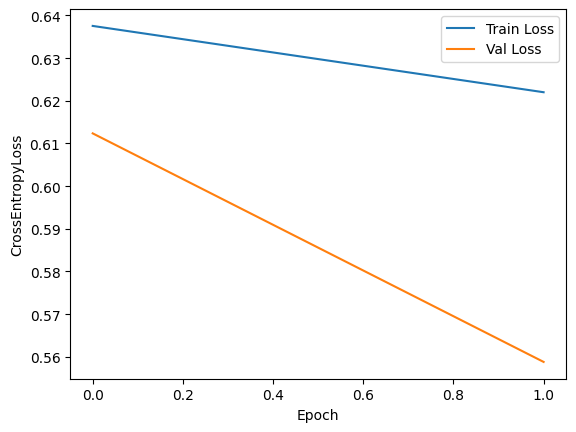

In [12]:
input_dim = train_data[0][0].shape[0]
#model = Network(input_dim=input_dim, hidden_dim=64, output_dim=N_LABELS)
model = CNN1d(input_dim=input_dim, hidden_dim=64, n_classes=N_LABELS)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = train(model, train_loader, val_loader, optimizer, criterion, N_EPOCHS, DEVICE, checkpoint_path=CHEKPOINT_FOLDER)

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropyLoss')
plt.legend()
plt.savefig(os.path.join(CHEKPOINT_FOLDER, 'loss.png'))
plt.show()

with open(os.path.join(CHEKPOINT_FOLDER, 'train_val_losses.csv'), 'w') as f:
    f.write('train_loss,val_loss\n')
    for train_loss, val_loss in zip(train_losses, val_losses):
        f.write(f'{train_loss},{val_loss}\n')

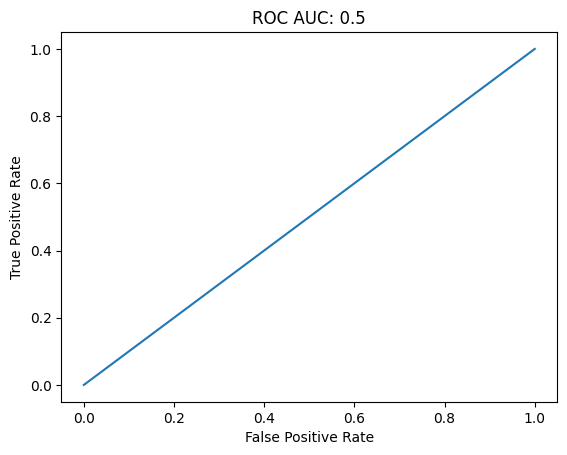

In [13]:
best_model_path = os.path.join(CHEKPOINT_FOLDER, 'best_model.t7')
model.load_state_dict(torch.load(best_model_path))
y_true, y_pred = test(model, test_loader, DEVICE, compute_roc=True)